In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [40]:
#handling our data
fraud_data = pd.read_csv("costsensitiveregression.csv")
col = fraud_data.columns.tolist()
col = col[-2:-1] + col[:-2] + col[-1:]
fraud_data = fraud_data[col]


X_train, X_test, y_train, y_test = train_test_split(
    fraud_data.iloc[:, 1:], fraud_data.iloc[:, 0], test_size=0.2, random_state=0
)

fnc_train= X_train["FNC"]
fnc_test = X_test["FNC"]

X_train = X_train.drop("FNC",axis = 1)
X_test = X_test.drop("FNC",axis  = 1)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [41]:
#defining sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#defining our cost sensitive loss function
def loss(y,y_pred,fnc):
    tpc  = 4
    fpc = 4
    tnc = 0
    loss = y * (y_pred* tpc + (1 - y_pred) * fnc) + (1 - y_pred) * (
            y_pred* fpc + (1 - y_pred) * tnc
        )
    return loss.mean()

In [42]:
#defining our fitness function which assigns a fitness score to each member
#in our population

def fitness(population,X,y,fnc):
    fitness = []
    for member in population:
        y_pred = sigmoid(np.dot(X, member))
        loss_t = loss(y,y_pred,fnc)
        fitness.append(1 / (1 + loss_t))
    return fitness

In [43]:
#Now for our genetic algorithm we define pop_sizes, mutation_rates, iters etc
pop_size = 50
max_iters = 1000
mutation_prob = 0.01

#Now we define our crossover function
def crossover(parent1,parent2):
    crossover_point = np.random.randint(len(parent1))
    child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    return child

#Now we define our mutation for each member in our population
def mutate(member,mutation_prob):
    mask = np.random.binomial(n=1, p=mutation_prob, size=len(member)).astype(bool)
    mutation = np.random.rand(sum(mask)) - 0.5
    member[mask] += mutation
    return member

In [44]:
#Now we define our fit function using the above defined functions
def fit(pop_size,max_iters,mutation_prob,X,y,fnc):
    loss_epoch = []
    #Now we generate our population randomly for checking
    population = np.random.rand(pop_size, X.shape[1]) - 0.5

    #Now we perform the optimization
    for i in range(max_iters):
        fitness_t = fitness(population,X,y,fnc)
        p1 = fitness_t/np.sum(fitness_t)
        parent1_idx = np.random.choice(range(pop_size),p = p1)
        parent2_idx = np.random.choice(range(pop_size),p = p1)

        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        child = crossover(parent1, parent2)
        child = mutate(child,mutation_prob)

        child_fitness = fitness([child], X, y,fnc)[0]
        worst_idx = np.argmin(fitness_t)
        best_idx = np.argmax(fitness_t)
        best_mem = population[best_idx]
        y_pred = sigmoid(np.dot(X_train,best_mem))
        loss_t = loss(y_train,y_pred,fnc_train)
        loss_epoch.append(loss_t)
        if child_fitness > fitness_t[worst_idx]:
            population[worst_idx] = child
    return population,loss_epoch
        

1.202384178367345


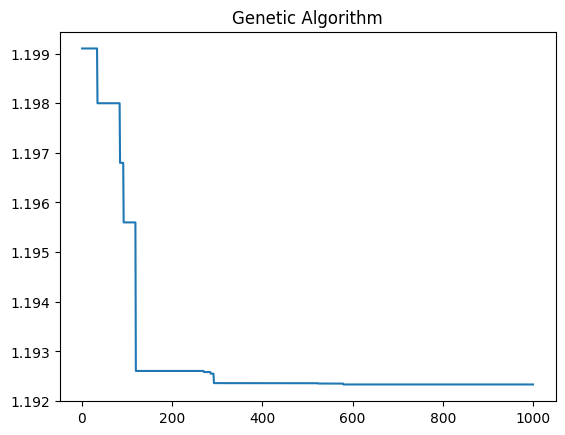

In [45]:
population,loss_epochs = fit(pop_size,max_iters,mutation_prob,X_train,y_train,fnc_train)

#now we have a population we need to find the accuracy
#before that let us find the best among the population
fitness_t = fitness(population,X_train,y_train,fnc_train)
best_idx = np.argmax(fitness_t)
best_member = population[best_idx]

#printing the loss
y_pred = sigmoid(np.dot(X_test,best_member))
loss_t = loss(y_test,y_pred,fnc_test)
print(loss_t)

x_axis = [i for i in range(1,max_iters+1)]
plt.plot(x_axis,loss_epochs)
plt.title("Genetic Algorithm")
plt.show()
